# Reproduction of "The Surprising Effectiveness of PPO in Cooperative Multi-Agent Games"
# https://arxiv.org/pdf/2103.01955

In [ ]:
%pip uninstall supersuit
# needed this fix to use all cores https://github.com/Farama-Foundation/SuperSuit/commit/e2c4f84f3c4af0df26ec204d873afa826728bbc6
%pip install git+https://github.com/Farama-Foundation/SuperSuit.git

Found existing installation: SuperSuit 3.10.0
Uninstalling SuperSuit-3.10.0:
  Would remove:
    /home/godjan/jupyterlab/.venv/lib/python3.12/site-packages/supersuit-3.10.0.dist-info/*
    /home/godjan/jupyterlab/.venv/lib/python3.12/site-packages/supersuit/*
Proceed (Y/n)? 

In [52]:
from mpe2 import simple_reference_v3
import supersuit as ss
import matplotlib.pyplot as plt
import os

In [163]:
env = simple_reference_v3.parallel_env(render_mode="rgb_array")


In [164]:
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, num_vec_envs=128, num_cpus=os.cpu_count())

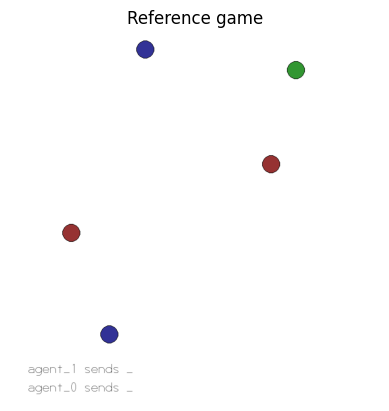

In [8]:
_ = env.reset()
plt.title("Reference game")
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.show()

In [56]:
env_return = env.reset()

In [58]:
print(env_return[0])

[[ 0.          0.         -0.25659284 ...  0.          0.
   0.        ]
 [ 0.          0.          0.05289812 ...  0.          0.
   0.        ]
 [ 0.          0.          0.82128847 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.11566323 ...  0.          0.
   0.        ]
 [ 0.          0.          0.65919644 ...  0.          0.
   0.        ]
 [ 0.          0.          0.8672402  ...  0.          0.
   0.        ]]


In [90]:
state = env.reset()

print(state[0].shape)

(256, 21)


In [51]:
env.action_space.sample()

np.int64(49)

In [61]:
observation_len = env.observation_space.shape[0]
state_len = 2 * observation_len
n_actions = env.action_space.n

In [152]:
import supersuit
print(supersuit.vector.vector_constructors.__file__)

/home/godjan/jupyterlab/.venv/lib/python3.12/site-packages/supersuit/vector/vector_constructors.py


In [66]:
import torch
import torch.nn as nn
import numpy as np
from torch.distributions import Categorical

In [189]:
# Network architecture and hyperparameters fro MPE envs from pages 16(C.4) and 26(Table 9)

NUM_FC = 2 # variable is not utilised, but self.fc has 2 layers
FC_DIM = 64
NUM_GRU = 1 # variable is not utilised, but self.rnn has 1 layer
RNN_DIM = 64
NUM_FC_AFTER = 1


class MPEReferenceNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, FC_DIM),
            nn.ReLU(), # page 28 (table 16)
            nn.Linear(FC_DIM, FC_DIM),
            nn.ReLU())
        self.rnn = nn.GRU(input_size=FC_DIM, hidden_size=RNN_DIM, num_layers=NUM_GRU, batch_first=True)
        self.fc_after = nn.Sequential(
            nn.Linear(RNN_DIM, FC_DIM),
            nn.ReLU())
        self.output_head = nn.Linear(FC_DIM, output_size)


    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        out_fc = self.fc(inp)
        out_rnn, _ = self.rnn(out_fc)
        out_fc_after = self.fc_after(out_rnn)
        out = self.output_head(out_fc_after)
        return out

    def step(self, inp: np.ndarray) -> torch.Tensor:
        tensor_input = torch.tensor(inp, dtype=torch.float32)
        return self.forward(tensor_input)

class Agent:
    def __init__(self, observation_len: int, n_actions: int):
        self.nn = MPEReferenceNetwork(observation_len, n_actions)
        self.dist = None

    def step(self, inp: np.ndarray) -> torch.Tensor:
        return self.nn.step(inp)

    def init_actions_dist(self, logits: torch.Tensor):
        self.dist = Categorical(logits=logits)

    def get_actions(self) -> int:
        return self.dist.sample()


def reference_observations_to_states(observations: torch.Tensor) -> torch.Tensor:
    observations = observations.reshape(observations.shape[0] // 2, observations.shape[1] * 2)
    return observations


        

class EnvRunner:
    def __init__(self, env):
        self.env = env
        self.latest_observation = env.reset()[0]

    def collect_trajectory(self, agent, critic, n_steps) -> tuple:
        batch_size = self.latest_observation.shape[0]
        obs_buf = np.zeros((n_steps, batch_size, self.latest_observation.shape[1]))
        rew_buf = np.zeros((n_steps, batch_size))
        term_buf = np.zeros((n_steps, batch_size))
        trunc_buf = np.zeros((n_steps, batch_size))
        info_buf = np.zeros((n_steps, batch_size))
        values_tensor = torch.zeros(n_steps, batch_size // 2)
        for i in range(n_steps - 1):
            logits = agent.step(self.latest_observation)
            agent.init_actions_dist(logits)
            actions = agent.get_actions()

            values = critic.step(reference_observations_to_states(self.latest_observation))
            observations, rewards, terminations, truncations, infos = env.step(actions)

            obs_buf[i] = self.latest_observation
            rew_buf[i] = rewards
            term_buf[i] = terminations
            trunc_buf[i] = truncations
            values_tensor[i] = values.squeeze(dim=-1)
            
            self.latest_observation = observations

        obs_buf[-1] = self.latest_observation
        rew_buf[-1] = np.zeros(batch_size)
        term_buf[-1] = np.zeros(batch_size)
        trunc_buf[-1] = np.zeros(batch_size)
        values_tensor[-1] = critic.step(reference_observations_to_states(self.latest_observation)).squeeze(dim=-1)
        

        obs_tensor = torch.from_numpy(obs_buf).float()
        rew_tensor = torch.from_numpy(rew_buf).float()
        term_tensor = torch.from_numpy(term_buf).float()
        trunc_tensor = torch.from_numpy(trunc_buf).float()
        info_tensor = torch.from_numpy(info_buf).float()
        
        return obs_tensor, rew_tensor, term_tensor, trunc_tensor, info_tensor, values_tensor
            

def get_resets(terminations: torch.Tensor, truncations: torch.Tensor):
    return torch.logical_or(terminations, truncations)


def compute_gae(resets: torch.Tensor, rewards: torch.Tensor, values: torch.Tensor, gamma: float, lamb: float) -> int:
    steps = values.shape[0]
    gae = torch.zeros(steps - 1, values.shape[1])
    adv = 0
    for i in reversed(range(steps - 1)):
        delta = rewards[i] + gamma * values[i + 1] - values[i]
        adv = torch.where(resets[i], delta, delta + gamma * lamb * adv)
        gae[i] = adv
        
    return gae
    
    
    

agent_reference = Agent(observation_len, n_actions)
critic_reference = MPEReferenceNetwork(state_len, 1)
env_runner = EnvRunner(env)

In [191]:
obs_tensor, rew_tensor, term_tensor, trunc_tensor, info_tensor, values_tensor = env_runner.collect_trajectory(agent_reference, critic_reference, 10)
resets = get_resets(term_tensor, trunc_tensor)
compute_gae(resets, rew_tensor, values_tensor.repeat_interleave(2, dim=-1), 0.5, 0.9)

tensor([[-2.5511, -3.0002, -1.4274,  ..., -2.4619, -1.3387, -2.1395],
        [-2.5038, -3.0537, -1.3987,  ..., -2.5306, -1.4171, -2.2480],
        [-2.5328, -3.1392, -1.3302,  ..., -2.6023, -1.5169, -2.3696],
        ...,
        [-2.5233, -3.3410, -0.9920,  ..., -2.4148, -1.6416, -2.4415],
        [-2.2438, -2.9944, -0.8346,  ..., -2.0857, -1.4494, -2.1474],
        [-1.5767, -2.0831, -0.5598,  ..., -1.4358, -0.9939, -1.4593]],
       grad_fn=<CopySlices>)

In [78]:
logits = agent_reference.step(env_return[0])
agent_reference.init_actions_dist(logits)
actions = agent_reference.get_actions()

In [77]:
critic_reference.step(reference_observations_to_states(env_return[0])).shape

torch.Size([128, 1])

In [80]:
actions.shape

torch.Size([256])

In [87]:
env.step(actions)[1].shape

(256,)

In [88]:
env_return[0]

array([[ 0.        ,  0.        , -0.25659284, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.05289812, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.82128847, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.11566323, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.65919644, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.8672402 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [94]:
actor_reference.step(np.expand_dims(env.observe(env.agents[0]), axis=0)).shape

torch.Size([1, 50])

In [95]:
critic_reference.step((np.expand_dims(env.state(), axis=0))).shape

torch.Size([1, 1])

In [96]:
import supersuit as ss

ModuleNotFoundError: No module named 'supersuit'

In [54]:
observation, reward, termination, truncation, info = env.last()
observation

array([ 0.24554661,  0.5197992 ,  0.29575133, -0.9656828 , -0.72458404,
       -0.63708955, -0.32575297, -1.6365997 ,  0.75      ,  0.25      ,
        0.25      ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [55]:
env.state()

array([ 0.24554661,  0.5197992 ,  0.29575133, -0.9656828 , -0.72458404,
       -0.63708955, -0.32575297, -1.6365997 ,  0.75      ,  0.25      ,
        0.25      ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.36229587,  0.39657515, -0.32308513, -1.2671725 ,
       -1.3434205 , -0.9385792 , -0.94458944, -1.9380894 ,  0.25      ,
        0.75      ,  0.25      ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [60]:
env.observe(env.agents[0])

array([ 0.24554661,  0.5197992 ,  0.29575133, -0.9656828 , -0.72458404,
       -0.63708955, -0.32575297, -1.6365997 ,  0.75      ,  0.25      ,
        0.25      ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [61]:
env.observe(env.agents[1])

array([-0.36229587,  0.39657515, -0.32308513, -1.2671725 , -1.3434205 ,
       -0.9385792 , -0.94458944, -1.9380894 ,  0.25      ,  0.75      ,
        0.25      ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)